# Vector Pipeline

## Setting Path

In [1]:
import sys
sys.path.append('../Code Files')
sys.path.append('../Data')

## Import Libraries

In [2]:
import numpy as np
import scipy
import re
import pandas as pd
from optimization import SGD1, SGD2
import matplotlib.pyplot as plt

## Prepare HCP Data

In [3]:
with open("../Data/fmri_rs.npy", "rb") as f:
  fmri_rs = np.load(f)

#Each sample is a row
fmri_rs = fmri_rs.T

#Get Split to divide into train + test
mat_file = scipy.io.loadmat("../Data/MMP_HCP_60_splits.mat")
seed_1 = mat_file['folds']['seed_1']
subject_lists = seed_1[0, 0]['sub_fold'][0, 0]['subject_list']
test_subjects = [int(item[0]) for item in subject_lists[0,0].flatten()]

#Get HCP test subjects
HCP_753_Subjects = []
with open('../Data/MMP_HCP_753_subs.txt', 'r') as file:
    HCP_753_Subjects = [int(re.sub('\n', '', line)) for line in file.readlines()]

#Put the HCP test subjects into a dataframe
df = pd.read_csv("../Data/MMP_HCP_componentscores.csv")
df['Subject'] = pd.to_numeric(df['Subject'], errors='coerce')
df = df[df['Subject'].isin(HCP_753_Subjects)].reset_index(drop = True)

#Split all our data into a Train and Test Set
df_train, df_test = df[~df['Subject'].isin(test_subjects)], df[df['Subject'].isin(test_subjects)]

In [4]:
#Create train and test arrays
train_subjects = df_train.index.to_list()
test_subjects = df_test.index.to_list()

X_train, Y_train = fmri_rs[train_subjects], df_train["varimax_cog"].to_numpy().reshape((-1, 1))
X_test, Y_test = fmri_rs[test_subjects], df_test["varimax_cog"].to_numpy().reshape((-1, 1))

## Run Experiments

In [5]:
lamb = 5
lr = 0.0005
epochs = 1500
batch_size = 64
W_estimated, b_estimated, losses = SGD2(X = X_train, Y = Y_train, lr = lr, lamb = lamb, epochs = epochs, batch_size = batch_size, bias = False)

Epoch [1/1500], Loss: 393306.0000
Epoch [2/1500], Loss: 389372.8438
Epoch [3/1500], Loss: 385483.6250
Epoch [4/1500], Loss: 381635.3438
Epoch [5/1500], Loss: 377820.9688
Epoch [6/1500], Loss: 374055.3438
Epoch [7/1500], Loss: 370308.4688
Epoch [8/1500], Loss: 366609.7188
Epoch [9/1500], Loss: 362960.0938
Epoch [10/1500], Loss: 359324.1875
Epoch [11/1500], Loss: 355755.4688
Epoch [12/1500], Loss: 352181.2812
Epoch [13/1500], Loss: 348663.2812
Epoch [14/1500], Loss: 345181.8750
Epoch [15/1500], Loss: 341748.2812
Epoch [16/1500], Loss: 338323.2500
Epoch [17/1500], Loss: 334943.0625
Epoch [18/1500], Loss: 331599.2500
Epoch [19/1500], Loss: 328288.7812
Epoch [20/1500], Loss: 325011.7188
Epoch [21/1500], Loss: 321766.9688
Epoch [22/1500], Loss: 318569.7500
Epoch [23/1500], Loss: 315378.8125
Epoch [24/1500], Loss: 312230.0938
Epoch [25/1500], Loss: 309113.7500
Epoch [26/1500], Loss: 306019.9375
Epoch [27/1500], Loss: 302968.6562
Epoch [28/1500], Loss: 299966.8125
Epoch [29/1500], Loss: 296951

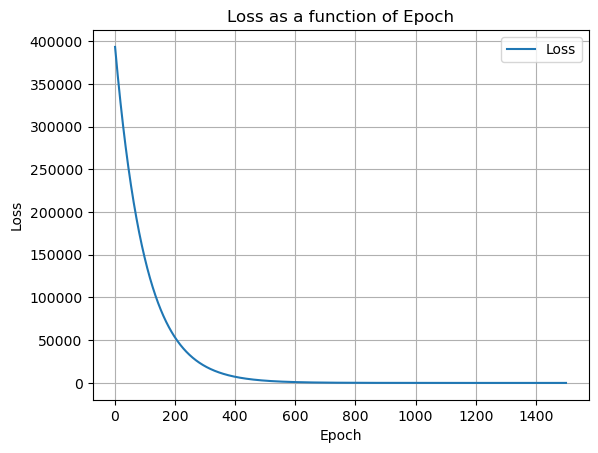

In [6]:
plt.plot(range(1, len(losses)+1), losses, label='Loss')
plt.title('Loss as a function of Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()